## Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append('..')
print(sys.path)
import os
from DeepSolarEye.handling.split_data import train_test_val_split
from DeepSolarEye.handling.load_tensor import get_numerical_data, load_and_process_image, load_tensor
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from DeepSolarEye.dl_logic.model import regression_ResNet
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

['/Users/peterbitman/Desktop/Deep_Solar_Eye/notebooks', '/Users/peterbitman/code/pemabi/04-Decision-Science/01-Project-Setup/data-context-and-setup', '/Users/peterbitman/Desktop/Deep_Solar_Eye/notebooks', '/Users/peterbitman/.pyenv/versions/3.10.6/lib/python310.zip', '/Users/peterbitman/.pyenv/versions/3.10.6/lib/python3.10', '/Users/peterbitman/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload', '', '/Users/peterbitman/.pyenv/versions/3.10.6/envs/Deep_Solar_Eye/lib/python3.10/site-packages', '..', '..']


## Data Loading and Preprocessing

__Split Data:__\
Splits raw data into three new directories (train_data, test_data. va;_data), to the specified ratios. Ratios are relative to the total number of images in raw data (can be less than 1 to limit amount of data introduced to model)

In [7]:
train_test_val_split(train_ratio=0.02, test_ratio=0.007, val_ratio=0.005)

3it [00:01,  1.69it/s]

train size: 915
test_size: 320
val_size: 228


Load and Preprocess Numerical Data

In [8]:
path_test = "test_data"
path_train = "train_data"
path_val = "val_data"

df_test = get_numerical_data(path_test)
df_train = get_numerical_data(path_train)
df_val = get_numerical_data(path_val)

Batch and Preprocess Images

In [9]:
train_ds, batch_size = load_tensor(df_train, 16, path_train)
test_ds, batch_size = load_tensor(df_test, 16, path_test)
val_ds, batch_size = load_tensor(df_val, 16, path_val)

## Define Model

In [10]:
model = regression_ResNet(model_name='ResNet50', input_shape=(224, 224, 3),input_time_irradiance=(2,), num_units=512, pretrained=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Define learning rate, optimizer, early stopping and RLR

In [11]:
initial_learning_rate = 0.01

optimizer = Adam(learning_rate=initial_learning_rate)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4
                              )

# Define the filepath for saving the model weights
checkpoint_filepath = '../DeepSolarEye/model_weights/first_model.h5'

# Define the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


Fit Model

In [12]:
history = model.fit(train_ds,
            epochs=500,
            batch_size=batch_size,
            validation_data=val_ds,
            callbacks=[early_stopping, reduce_lr, model_checkpoint_callback],
           )

Epoch 1/500
58/58 [==============================] - ETA: 0s - loss: 1.1271 - mae: 0.5855
Epoch 1: val_loss improved from inf to 1.15683, saving model to ../DeepSolarEye/model_weights/first_model.h5
58/58 [==============================] - 46s 773ms/step - loss: 1.1271 - mae: 0.5855 - val_loss: 1.1568 - val_mae: 0.9948 - lr: 0.0010
Epoch 2/500
58/58 [==============================] - ETA: 0s - loss: 0.7925 - mae: 0.7470
Epoch 2: val_loss improved from 1.15683 to 0.43951, saving model to ../DeepSolarEye/model_weights/first_model.h5
58/58 [==============================] - 42s 731ms/step - loss: 0.7925 - mae: 0.7470 - val_loss: 0.4395 - val_mae: 0.5731 - lr: 0.0010
Epoch 3/500
58/58 [==============================] - ETA: 0s - loss: 0.2345 - mae: 0.3881
Epoch 3: val_loss improved from 0.43951 to 0.24025, saving model to ../DeepSolarEye/model_weights/first_model.h5
58/58 [==============================] - 44s 759ms/step - loss: 0.2345 - mae: 0.3881 - val_loss: 0.2402 - val_mae: 0.4334 - l

## Evaluation and Test
Evaluate Model Performance

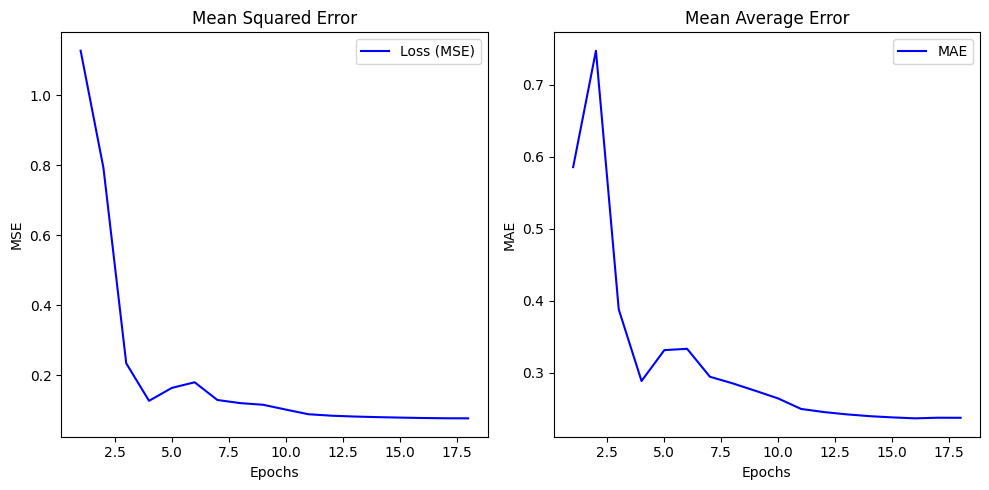

In [13]:
# Extracting metrics from history
mse = history.history['loss']
mae = history.history['mae']

# Plotting
epochs = range(1, len(mse) + 1)
plt.figure(figsize=(10, 5))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(epochs, mse, 'b', label='Loss (MSE)')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plot MSE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b', label='MAE')
plt.title('Mean Average Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Extracting test values from dataset

In [18]:
df_test.head()

,Seconds of Day,Percentage Loss,Irradiance Level
0,0.203803,0.025505,0.249158
1,0.937516,0.691072,0.117033
2,0.468361,0.645651,0.586244
3,0.896101,0.395413,0.140964
4,0.456822,0.032137,0.767104


In [23]:
# Initialize an empty list to store values from the specific column
y_test = []

# Iterate over the dataset and collect values from the specific column
for _, label_batch in test_ds:
    y_test.extend(label_batch.numpy())

# assert that test targets are equal to dataset targets
assert y_test == df_test['Percentage Loss'].values.tolist()

Make and evaluate predictions on test set

In [24]:
# Make predictions on new data
y_pred = model.predict(test_ds)
assert len(y_test) == len(y_pred)

20/20 [==============================] - 13s 587ms/step


In [25]:
# evaluate predictions
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = metrics.r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2_score)

Mean Absolute Error: 0.23808253
Mean Squared Error: 0.07662002
Root Mean Squared Error: 0.27680323
R-squared: -0.04641523541524162
